# Preprocessing for LDL

## Setting up Julia Jupyter Kernel

To use Julia on Jupyter Notebook, the package IJulia is needed. Install IJulia from the Julia REPL by pressing ] to enter pkg mode and entering:

```julia
(@v1.5) pkg> add IJulia
```
then
```julia
(@v1.5) pkg> build IJulia
```

Then the Julia kernel will be available on your Jupyter Notebook. 

## Package Installation

The following are the packages used in our analysis:
- Registered packages: CSV, DataFrames, StatsBase, DataStructures, Statistics, Plots, Ipopt, KNITRO (license needed)
- Unregistered packages: SnpArrays, VCFTools, BGEN, WiSER (private), vGWAS (private)

Registered packages can also be installed in the pkg mode of Julia REPL. 
```julia
(@v1.5) pkg> add CSV DataFrames StatsBase DataStructures Statistics Plots Ipopt
```

The vGWAS is the main analysis package. It depends on four other unregistered packages SnpArrays.jl, VCFTools.jl, BGEN.jl, and WiSER.jl. The package has not yet been registered and must be installed using the repository location. Start julia and use the ] key to switch to the package manager REPL and run:

```julia
(@v1.5) pkg> add https://github.com/OpenMendel/SnpArrays.jl
(@v1.5) pkg> add https://github.com/OpenMendel/VCFTools.jl
(@v1.5) pkg> add https://github.com/OpenMendel/BGEN.jl
(@v1.5) pkg> add https://github.com/OpenMendel/WiSER.jl
(@v1.5) pkg> add https://github.com/OpenMendel/vGWAS.jl
```

## Environment setup

The [environment](https://pkgdocs.julialang.org/v1.5/environments/) is defined by `Project.toml` and `Manifest.toml` files located in a certain directory. This is a tool to keep package versions consistent throughout different machines/users. You can copy `Project.toml` and `Manifest.toml` in this directory to your project directory, activate the environment, and instantiate it. KNITRO is not included in this project. In Pkg mode of Julia REPL:

```julia
(@v1.5) pkg> activate PROJECTDIR
(@v1.5) pkg> instantiate
```
where `PROJECTDIR` is the directory in which `Project.toml` and `Manifest.toml` exist. It can be `.` for the current working directory. You will need to run `instantiate` immediately after copying the toml files to your project directory. You will not need to run it thereafter. 
You might want to precompile the packages, especially before running the jobs on a cluster:
```julia
(@v1.5) pkg> precompile
```


In some cases, we might want to update the vGWAS package and possibly others (BGEN package in particular) during the experiment runs. In that case, we will update the toml files in this directory and notify you. Then you will need to copy the updated toml files to your directory then run `instantiate` again in the Pkg mode after activating the environment.



We can also activate environments by running 

In [1]:
using Pkg
pkg"activate ."

 Activating environment at `~/Box Sync/vGWAS/results/ukb_bgen/LDL/Project.toml`


In [2]:
using CSV, Dates, DataFrames
datadir = "../../../datasets/UKBclean"; # the location where the data files from vGWAS/datasets/UKBclean of Box are stored 

on Jupyter Notebooks. Running `pkg"..."` after running `using Pkg` is equivalent to running the command `...` on the Pkg mode of REPL.

## Reading data files and filtering

Start with EUR data: 337,138 samples.

In [3]:
phenotype_info = CSV.read(datadir * "/EUR.txt", DataFrame)
data_center = CSV.read(datadir * "/assessment_center.csv", DataFrame)
phenotype_info = leftjoin(phenotype_info, data_center, on=[:FID=>:FID], makeunique=true)

,FID,IID,AcIsch,MI,PCI,Angina_unstable,Stroke_infarct,Stroke_hem
,Int64,Int64,String,String,String,String,String,String
1,1000012,1000012,0,0,0,0,0,0
2,1000031,1000031,0,0,0,0,0,0
3,1000047,1000047,0,0,0,0,0,0
4,1000073,1000073,0,0,0,0,0,0
5,1000085,1000085,0,0,0,0,0,0
6,1000094,1000094,0,0,0,0,0,0
7,1000101,1000101,0,0,0,0,0,0
8,1000119,1000119,0,0,0,0,0,0
9,1000122,1000122,0,0,0,0,0,0


## Filtering out samples with missing covariates

Filtering out samples with missing covariates we need: `SEX`, `age_2010`, `PC1`, `BMI`, `self_cholesteroldrugs`. 

Sex. No missing there. 

[TODO] UK Biobank uses 0 for females and 1 for males ([source](https://biobank.ctsu.ox.ac.uk/crystal/coding.cgi?id=9)), but we have 1's and 2's here. Which is for which?

In [4]:
using StatsBase

In [5]:
counts(phenotype_info.SEX)

2-element Array{Int64,1}:
 156111
 181027

Age at year 2010. This is later used for age at measurement (age_2010 + year_of_measurement - 2010). No missing again. 

In [6]:
count(isnan.(phenotype_info.age_2010))

0

PC1. no missing again. 

In [7]:
count(isnan.(phenotype_info.PC1))

0

BMI. Some missing exists. Filtered out 337,138 - 336,118 = 1,020 samples. 

In [8]:
phenotype_info.BMI = map(x -> x == "NA" ? missing : parse(Float64, x), phenotype_info.BMI)
phenotype_info = filter(x -> x.BMI !== missing, phenotype_info)

,FID,IID,AcIsch,MI,PCI,Angina_unstable,Stroke_infarct,Stroke_hem
,Int64,Int64,String,String,String,String,String,String
1,1000012,1000012,0,0,0,0,0,0
2,1000031,1000031,0,0,0,0,0,0
3,1000047,1000047,0,0,0,0,0,0
4,1000073,1000073,0,0,0,0,0,0
5,1000085,1000085,0,0,0,0,0,0
6,1000094,1000094,0,0,0,0,0,0
7,1000101,1000101,0,0,0,0,0,0
8,1000119,1000119,0,0,0,0,0,0
9,1000122,1000122,0,0,0,0,0,0


Indicator for cholesterol medication. Some missing exists. Filtered out 336,118 - 334,320 = 1,798 samples.

In [9]:
phenotype_info.self_cholesteroldrugs = map(x -> x == "NA" ? missing : parse(Int, x), phenotype_info.self_cholesteroldrugs)
phenotype_info = filter(x -> x.self_cholesteroldrugs !== missing, phenotype_info)

,FID,IID,AcIsch,MI,PCI,Angina_unstable,Stroke_infarct,Stroke_hem
,Int64,Int64,String,String,String,String,String,String
1,1000012,1000012,0,0,0,0,0,0
2,1000031,1000031,0,0,0,0,0,0
3,1000047,1000047,0,0,0,0,0,0
4,1000073,1000073,0,0,0,0,0,0
5,1000085,1000085,0,0,0,0,0,0
6,1000094,1000094,0,0,0,0,0,0
7,1000101,1000101,0,0,0,0,0,0
8,1000119,1000119,0,0,0,0,0,0
9,1000122,1000122,0,0,0,0,0,0


In [10]:
countmap(phenotype_info.self_cholesteroldrugs)

Dict{Union{Missing, Int64},Int64} with 2 entries:
  0 => 270561
  1 => 63759

## Read in LDL data

In [11]:
ldl_info = CSV.read(datadir * "/LDL.txt", DataFrame)
ldl_info = rename(ldl_info,  Symbol("eid") => :FID)
sort!(ldl_info, [:FID, :event_dt])

,FID,LDL,event_dt,data_provider,code,terminology,term_description
,Int64,Float64,String?,Int64,String,String,String
1,1000068,1.6,02/08/2011,3,44P6.,read3,Serum LDL cholesterol level
2,1000068,1.7,06/10/2008,3,44P6.,read3,Serum LDL cholesterol level
3,1000068,1.9,09/02/2009,3,44P6.,read3,Serum LDL cholesterol level
4,1000068,1.9,09/08/2013,3,44P6.,read3,Serum LDL cholesterol level
5,1000068,1.7,10/06/2014,3,44P6.,read3,Serum LDL cholesterol level
6,1000068,1.6,17/04/2015,3,44P6.,read3,Serum LDL cholesterol level
7,1000068,1.8,17/08/2012,3,44P6.,read3,Serum LDL cholesterol level
8,1000068,4.4,30/07/2004,3,44P6.,read3,Serum LDL cholesterol level
9,1000094,1.9,10/12/2008,3,44P6.,read3,Serum LDL cholesterol level


Number of subjects with ldl data: 

In [12]:
length(unique(ldl_info[!, :FID]))

146841

## Join ldl data with phenotypes

Leftjoin ldl_info and phenotype_info.

In [13]:
@time ldl_info_joined = leftjoin(ldl_info, phenotype_info, on=[:FID=>:FID], makeunique=true)

  5.284315 seconds (2.10 M allocations: 767.530 MiB, 26.09% gc time)


,FID,LDL,event_dt,data_provider,code,terminology,term_description
,Int64,Float64,String?,Int64,String,String,String
1,1000068,1.6,02/08/2011,3,44P6.,read3,Serum LDL cholesterol level
2,1000068,1.7,06/10/2008,3,44P6.,read3,Serum LDL cholesterol level
3,1000068,1.9,09/02/2009,3,44P6.,read3,Serum LDL cholesterol level
4,1000068,1.9,09/08/2013,3,44P6.,read3,Serum LDL cholesterol level
5,1000068,1.7,10/06/2014,3,44P6.,read3,Serum LDL cholesterol level
6,1000068,1.6,17/04/2015,3,44P6.,read3,Serum LDL cholesterol level
7,1000068,1.8,17/08/2012,3,44P6.,read3,Serum LDL cholesterol level
8,1000068,4.4,30/07/2004,3,44P6.,read3,Serum LDL cholesterol level
9,1000094,1.9,10/12/2008,3,44P6.,read3,Serum LDL cholesterol level


Filter out rows with no phenotype information (non-EUR or missing BMI, etc.)

In [14]:
683387 - 449626 #rows filtered out 

233761

In [15]:
ldl_info_joined = filter(x -> x.IID !== missing, ldl_info_joined)

,FID,LDL,event_dt,data_provider,code,terminology,term_description
,Int64,Float64,String?,Int64,String,String,String
1,1000094,1.9,10/12/2008,3,44P6.,read3,Serum LDL cholesterol level
2,1000094,2.5,14/12/2011,3,44P6.,read3,Serum LDL cholesterol level
3,1000094,2.1,16/09/2009,3,44P6.,read3,Serum LDL cholesterol level
4,1000094,2.8,18/04/2016,3,44P6.,read3,Serum LDL cholesterol level
5,1000094,4.7,18/07/2008,3,44P6.,read3,Serum LDL cholesterol level
6,1000094,3.5,19/02/2014,3,44P6.,read3,Serum LDL cholesterol level
7,1000094,2.0,19/06/2013,3,44P6.,read3,Serum LDL cholesterol level
8,1000094,2.2,19/09/2012,3,44P6.,read3,Serum LDL cholesterol level
9,1000094,2.2,25/03/2011,3,44P6.,read3,Serum LDL cholesterol level


In [16]:
length(unique(ldl_info_joined.FID))

98556

We are left with 98,556 samples. 

* Samples in EUR but without LDL measurements: 334,320 - 98,556 = 235,764.
* Samples with lipid measurement but not in EUR: 146,841 - 98,556 =  48,285

## Cleaning measurement dates and age at measurements

Remove rows with missing measurement dates. This drops 0 further samples.

In [17]:
449_626 - 449_616

10

In [18]:
ldl_info_joined = filter(x -> x.event_dt !== missing, ldl_info_joined)

,FID,LDL,event_dt,data_provider,code,terminology,term_description
,Int64,Float64,String?,Int64,String,String,String
1,1000094,1.9,10/12/2008,3,44P6.,read3,Serum LDL cholesterol level
2,1000094,2.5,14/12/2011,3,44P6.,read3,Serum LDL cholesterol level
3,1000094,2.1,16/09/2009,3,44P6.,read3,Serum LDL cholesterol level
4,1000094,2.8,18/04/2016,3,44P6.,read3,Serum LDL cholesterol level
5,1000094,4.7,18/07/2008,3,44P6.,read3,Serum LDL cholesterol level
6,1000094,3.5,19/02/2014,3,44P6.,read3,Serum LDL cholesterol level
7,1000094,2.0,19/06/2013,3,44P6.,read3,Serum LDL cholesterol level
8,1000094,2.2,19/09/2012,3,44P6.,read3,Serum LDL cholesterol level
9,1000094,2.2,25/03/2011,3,44P6.,read3,Serum LDL cholesterol level


In [19]:
length(unique(ldl_info_joined.FID))

98556

Obtain year of measurement and age at measurement:

In [20]:
using Dates
dateform = DateFormat("d/m/y")

dateformat"d/m/y"

In [21]:
# ldl_info_joined.year_of_measurement = map(x -> parse(Int, x.event_dt[1:4]), eachrow(ldl_info_joined));
ldl_info_joined.year_of_measurement = map(x -> year(Date(x.event_dt, dateform)), eachrow(ldl_info_joined));

In [22]:
# ldl_info_joined.age_at_measurement = map(x -> x.age_2010 + parse(Int, x.event_dt[1:4]) - 2010, eachrow(ldl_info_joined));
ldl_info_joined.age_at_measurement = map(x -> x.age_2010 + year(Date(x.event_dt, dateform)) - 2010, eachrow(ldl_info_joined));

[TODO] Some of the year of measurements are too old or even in the future. Maybe we should filter pre-1990 and 2037 measurements? This would drop only 13 subjects.

Special meaning for year 1901 1902, and 1903, 2037

https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?tk=68EMKkCB8skqob929k0lJTa0eLbPoYnY157881&id=819


| Date | Meaning |
|:---|:---|
| 1900-01-01 |	Code has no event date |
| 1901-01-01 |	Code has event date before participant's date of birth |
| 1902-02-02 |	Code has event date matching participant's date of birth |
| 1903-03-03 |	Code has event date after participant's date of birth and falls in the same calendar year as date of birth |
| 2037-07-07 |	Code has event date in the future and is presumed to be a place-holder or other system default |

We remove them. 

In [23]:
minimum(ldl_info_joined.age_at_measurement)

-62

In [24]:
maximum(ldl_info_joined.age_at_measurement)

79

In [25]:
yom_map = countmap(ldl_info_joined.year_of_measurement);
for v in sort(yom_map)
    println(v)
end

1902 => 8
1903 => 1
1966 => 1
1985 => 1
1989 => 2
1990 => 12
1991 => 25
1992 => 56
1993 => 82
1994 => 121
1995 => 136
1996 => 193
1997 => 332
1998 => 589
1999 => 952
2000 => 1802
2001 => 3738
2002 => 7508
2003 => 11881
2004 => 17920
2005 => 21103
2006 => 25991
2007 => 28969
2008 => 31088
2009 => 34348
2010 => 36150
2011 => 37066
2012 => 39097
2013 => 42702
2014 => 39250
2015 => 38338
2016 => 23640
2017 => 6514


In [26]:
449_616 - 449_607

9

In [27]:
ldl_info_joined = filter(x -> 1904 <= x.year_of_measurement <= 2017, ldl_info_joined)

,FID,LDL,event_dt,data_provider,code,terminology,term_description
,Int64,Float64,String?,Int64,String,String,String
1,1000094,1.9,10/12/2008,3,44P6.,read3,Serum LDL cholesterol level
2,1000094,2.5,14/12/2011,3,44P6.,read3,Serum LDL cholesterol level
3,1000094,2.1,16/09/2009,3,44P6.,read3,Serum LDL cholesterol level
4,1000094,2.8,18/04/2016,3,44P6.,read3,Serum LDL cholesterol level
5,1000094,4.7,18/07/2008,3,44P6.,read3,Serum LDL cholesterol level
6,1000094,3.5,19/02/2014,3,44P6.,read3,Serum LDL cholesterol level
7,1000094,2.0,19/06/2013,3,44P6.,read3,Serum LDL cholesterol level
8,1000094,2.2,19/09/2012,3,44P6.,read3,Serum LDL cholesterol level
9,1000094,2.2,25/03/2011,3,44P6.,read3,Serum LDL cholesterol level


In [28]:
length(unique(ldl_info_joined.FID))

98556

In [29]:
minimum(ldl_info_joined.age_at_measurement)

21

In [30]:
maximum(ldl_info_joined.age_at_measurement)

79

In [31]:
nobs = countmap(ldl_info_joined.FID)
findmax(nobs)

(92, 2088688)

In [32]:
nobs[2088688]

92

Ages at measurement with the remaining data lies between 20-79, which is way more reasonable.

## Shifting

We will shift based on [this NEJM link](https://www.nejm.org/doi/10.1056/NEJMoa1600176?url_ver=Z39.88-2003&rfr_id=ori%3Arid%3Acrossref.org&rfr_dat=cr_pub++0www.ncbi.nlm.nih.gov)
```
The LDL cholesterol level (measured in the subsample of participants described in the Methods section) was 39.6 mg per deciliter (1.02 mmol per liter) lower in the rosuvastatin group than in the placebo group at 1 year.
```
LDL 

In [33]:
ldl_info_joined[!, :ldl_shifted] = map(x -> x.self_cholesteroldrugs == 1 ? x.LDL + 1.02 :
                               x.LDL, eachrow(ldl_info_joined)) # figure out shift rate

449607-element Array{Float64,1}:
 1.9
 2.5
 2.1
 2.8
 4.7
 3.5
 2.0
 2.2
 2.2
 2.3
 2.1
 3.4
 3.7
 ⋮
 1.6
 1.4
 3.4
 1.4
 2.75
 1.8
 1.6
 2.3
 1.9
 3.0
 1.9
 1.6

## Standardization

We compute standardized age, bmi, etc. before splitting diabetic and nondiabetic samples.  

In [54]:
using Statistics
standardizes(x) = (x .- mean(skipmissing(x))) ./ std(skipmissing(x))
ldl_info_joined[!, :std_age] = standardizes(ldl_info_joined[!, :age_at_measurement])
ldl_info_joined[!, :std_age_sq] = map(x -> x.std_age ^ 2, eachrow(ldl_info_joined))
ldl_info_joined[!, :std_bmi] = standardizes(ldl_info_joined[!, :BMI])
ldl_info_joined[!, :log_ldl] = log.(ldl_info_joined[!, :ldl_shifted]);
ldl_info_joined[!, :std_ldl] = standardizes(ldl_info_joined[!, :ldl_shifted]);

## Split

Now we split the data into diabetic samples and nondiabetic samples. 

In [55]:
diabetics = CSV.read(datadir * "/diabetics.txt", DataFrame)[!, :FID]
using DataStructures
diabetics_map = DefaultDict{Int, Bool}(false)
for v in diabetics
    diabetics_map[v] = true
end

We have 13,193 diabetic samples remaining: 

In [56]:
ldl_info_diabetics = filter(x -> diabetics_map[x.FID], ldl_info_joined)

,FID,LDL,event_dt,data_provider,code,terminology,term_description
,Int64,Float64,String?,Int64,String,String,String
1,1000602,3.0,12/08/2005,3,44P6.,read3,Serum LDL cholesterol level
2,1000602,2.3,13/04/2007,3,44P6.,read3,Serum LDL cholesterol level
3,1000602,2.4,21/09/2007,3,44P6.,read3,Serum LDL cholesterol level
4,1000602,2.2,25/11/2005,3,44P6.,read3,Serum LDL cholesterol level
5,1001084,1.4,01/02/2016,3,44P6.,read3,Serum LDL cholesterol level
6,1001452,3.3,03/08/2015,3,44P6.,read3,Serum LDL cholesterol level
7,1001452,3.5,03/12/2012,3,44P6.,read3,Serum LDL cholesterol level
8,1001452,3.8,05/06/2008,3,44P6.,read3,Serum LDL cholesterol level
9,1001452,3.6,06/11/2006,3,44P6.,read3,Serum LDL cholesterol level


In [57]:
length(unique(ldl_info_diabetics.FID))

10631

In [58]:
d = countmap(ldl_info_diabetics.FID)
diabetic_measurements = []
for (k, v) in d
    push!(diabetic_measurements, v)
end

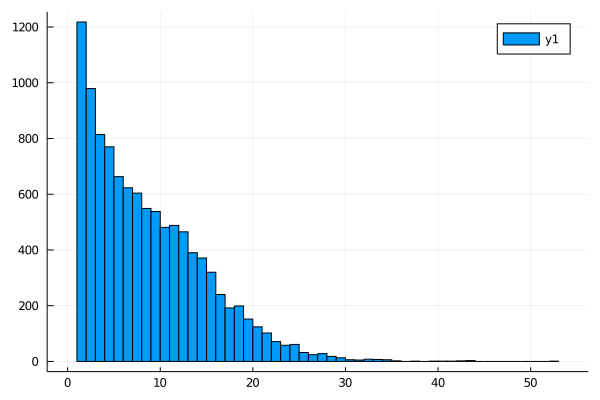

In [59]:
using Plots
histogram(diabetic_measurements)

In [60]:
CSV.write("ldl_diabetics.csv", ldl_info_diabetics)

"ldl_diabetics.csv"

And we have 135,664 nondiabetic samples remaining. 

In [61]:
ldl_info_nondiabetics = filter(x -> !diabetics_map[x.FID], ldl_info_joined)

,FID,LDL,event_dt,data_provider,code,terminology,term_description
,Int64,Float64,String?,Int64,String,String,String
1,1000094,1.9,10/12/2008,3,44P6.,read3,Serum LDL cholesterol level
2,1000094,2.5,14/12/2011,3,44P6.,read3,Serum LDL cholesterol level
3,1000094,2.1,16/09/2009,3,44P6.,read3,Serum LDL cholesterol level
4,1000094,2.8,18/04/2016,3,44P6.,read3,Serum LDL cholesterol level
5,1000094,4.7,18/07/2008,3,44P6.,read3,Serum LDL cholesterol level
6,1000094,3.5,19/02/2014,3,44P6.,read3,Serum LDL cholesterol level
7,1000094,2.0,19/06/2013,3,44P6.,read3,Serum LDL cholesterol level
8,1000094,2.2,19/09/2012,3,44P6.,read3,Serum LDL cholesterol level
9,1000094,2.2,25/03/2011,3,44P6.,read3,Serum LDL cholesterol level


In [62]:
length(unique(ldl_info_nondiabetics.FID))

87925

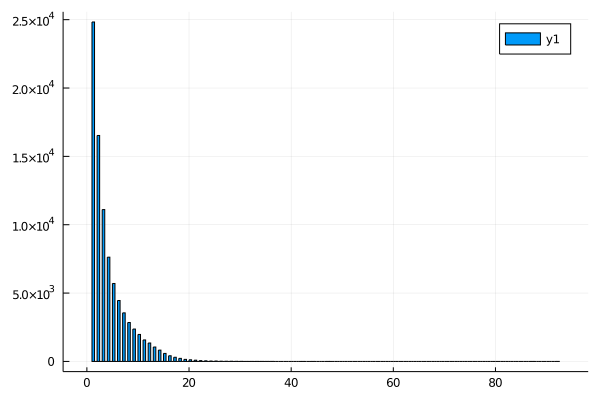

In [63]:
d = countmap(ldl_info_nondiabetics.FID)
nondiabetic_measurements = []
for (k, v) in d
    push!(nondiabetic_measurements, v)
end
histogram(nondiabetic_measurements)

In [64]:
CSV.write("ldl_nondiabetics.csv", ldl_info_nondiabetics)

"ldl_nondiabetics.csv"

In [65]:
using CSV, DataFrames
df = CSV.read("ldl_nondiabetics.csv", DataFrame)

,FID,LDL,event_dt,data_provider,code,terminology,term_description
,Int64,Float64,String,Int64,String,String,String
1,1000094,1.9,10/12/2008,3,44P6.,read3,Serum LDL cholesterol level
2,1000094,2.5,14/12/2011,3,44P6.,read3,Serum LDL cholesterol level
3,1000094,2.1,16/09/2009,3,44P6.,read3,Serum LDL cholesterol level
4,1000094,2.8,18/04/2016,3,44P6.,read3,Serum LDL cholesterol level
5,1000094,4.7,18/07/2008,3,44P6.,read3,Serum LDL cholesterol level
6,1000094,3.5,19/02/2014,3,44P6.,read3,Serum LDL cholesterol level
7,1000094,2.0,19/06/2013,3,44P6.,read3,Serum LDL cholesterol level
8,1000094,2.2,19/09/2012,3,44P6.,read3,Serum LDL cholesterol level
9,1000094,2.2,25/03/2011,3,44P6.,read3,Serum LDL cholesterol level


In [66]:
using StatsBase

In [67]:
d = countmap(df.FID)
nondiabetic_measurements = []
for (k, v) in d
    if v > 200
        println(k)
    end
    push!(nondiabetic_measurements, v)
end
#histogram(nondiabetic_measurements)

In [68]:
diabetic_samples = unique(ldl_info_diabetics.FID);
nondiabetic_samples = unique(ldl_info_nondiabetics.FID);

In [69]:
io = open("diabetes_subjects_ldl.txt", "w")
for v in diabetic_samples
    println(io, v)
end
close(io)

In [70]:
io = open("nondiabetes_subjects_ldl.txt", "w")
for v in nondiabetic_samples
    println(io, v)
end
close(io)

In [71]:
length(nondiabetic_samples)

87925

In [72]:
unique(ldl_info_nondiabetics[!, :center])

22-element Array{Union{Missing, String},1}:
 "Newcastle"
 "Sheffield"
 "Nottingham"
 "Reading"
 "Birmingham"
 "Cardiff"
 "Hounslow"
 "Leeds"
 "Edinburgh"
 "Middlesborough"
 "Bury"
 "Oxford"
 "Stoke"
 "Swansea"
 "Glasgow"
 "Bristol"
 "Croydon"
 "Manchester"
 "Liverpool"
 "Barts"
 "Wrexham"
 "Stockport (pilot)"

In [73]:
unique(data_center[!, :center])

22-element Array{String,1}:
 "Nottingham"
 "Bury"
 "Sheffield"
 "Glasgow"
 "Croydon"
 "Liverpool"
 "Leeds"
 "Reading"
 "Birmingham"
 "Swansea"
 "Cardiff"
 "Newcastle"
 "Middlesborough"
 "Bristol"
 "Hounslow"
 "Barts"
 "Edinburgh"
 "Stoke"
 "Oxford"
 "Manchester"
 "Stockport (pilot)"
 "Wrexham"

## Fitting the null model

Content of null_fitter_ldl_diabetes.jl: 

```julia
using DataFrames, CSV
using Statistics
using vGWAS
using Ipopt, WiSER
using LinearAlgebra
using KNITRO
using BGEN
# fit the null model
BLAS.set_num_threads(1)
solver = KNITRO.KnitroSolver(outlev=3) # outlev 0-6

genetic_iids_subsample = CSV.read("diabetes_subjects_ldl.txt", DataFrame; header=false)[!, 1]


ldl_data = CSV.read("ldl_diabetics.csv", DataFrame)
genetic_iids_subsample = unique(ldl_data.FID)
@time nm = vgwas(@formula(std_ldl ~ 1 + SEX + std_age + std_age_sq +
        PC1 + PC2 + PC3 + PC4 + PC5 + std_bmi),
    @formula(std_ldl ~ 1 + std_age),
    @formula(std_ldl ~ 1 + SEX + std_age + std_age_sq +
        PC1 + PC2 + PC3 + PC4 + PC5 +
        std_bmi),
    :IID,
    ldl_data,
    nothing;
    nullfile="ldl.test.diabetics.null.txt",
    solver=solver,
    runs=10
)

println(nm)
using Serialization
open("fittednullmodel.ldl.test.diabetics.jls", "w") do io
    Serialization.serialize(io, nm)
end
```
- change `std_ldl` to `std_hdl` for analyzing sldl
- change `diabetes` or `diabetics` to `nondiabetics` or `nondiabetes` for analyzing non-diabetes participants
- Knitro is a commercial library installed on Hua's desktop. We decided to fit the null model only on Hua's machine, and when Aubrey needs to fit a null model, the data or the fitted null models will be shared through Box. 

## Running vGWAS on a cluster

The julia script for actual score test (scoretest_ldl.jl) for a piece of BGEN file:

```julia
using DataFrames, CSV
using Statistics
using vGWAS
using WiSER
using LinearAlgebra
using BGEN
# fit the null model
BLAS.set_num_threads(1)


using Serialization

bgendir = ARGS[1] # ../ukb_imputed
chr = ARGS[2] # 1 to 22
fitted_null = ARGS[3] # "fittednullmodel.ldl.test.diabetics.jls"
pvalfile = ARGS[4] # "ldl.test.diabetics.chr$(chr).txt"
chunkidx = parse(Int, ARGS[5])
nchunks  = parse(Int, ARGS[6])

nm = open(deserialize, fitted_null)
genetic_iids_subsample = nm.ids

bgenfilename = bgendir * "/ukb_imp_chr$(chr)_v3"
samplefilename = bgendir * "/ukb48152_imp_chr$(chr)_v3_s487317.sample"
mfifilename = bgendir * "/ukb_mfi_chr$(chr)_v3.txt"
ukb_data = Bgen(bgenfilename * ".bgen"; sample_path = samplefilename)
genetic_iids = map(x -> parse(Int, split(x, " ")[1]), samples(ukb_data))

order_dict = Dict{Int, Int}()
for (i, iid) in enumerate(genetic_iids)
    order_dict[iid] = i
end

# sort!(bp_data, order(:IID, by=x -> order_dict[x]))

sample_indicator = falses(length(genetic_iids))
for v in genetic_iids_subsample
    sample_indicator[order_dict[v]] = true
end

# GWAS for each chromosome


min_maf = 0.002
min_info_score = 0.3
min_hwe_pval = 1e-10


mfi = CSV.read(mfifilename, DataFrame; header=false)
mfi.Column8 = map(x -> x == "NA" ? NaN : parse(Float64, x), mfi.Column8) # Column8: info score
snpmask = (mfi.Column6 .> min_maf) .& (mfi.Column8 .> 0.3) # Column6: MAF

chunksize = n_variants(ukb_data) ÷ nchunks + (n_variants(ukb_data) % nchunks > 0 ? 1 : 0)
startidx = chunksize * (chunkidx - 1) + 1
endidx = min(chunksize * chunkidx, n_variants(ukb_data))
snpmask = snpmask[startidx:endidx]
println("running for variants $startidx to $endidx")

vgwas(nm, bgenfilename * ".bgen", count(sample_indicator);
    samplepath=samplefilename,
    pvalfile=pvalfile,
    snpinds=snpmask,
    min_hwe_pval = min_hwe_pval,
    bgenrowinds = sample_indicator,
    startidx = startidx,
    endidx = endidx,
    usespa=true)

```

- Command-line arguments
    - Argument 1: directory for the BGEN files. BGEN files (.bgen), BGEN index files (.bgen.bgi), and MFI files (.txt) should be included there.
    - Argument 2: chromosome
    - Argument 3: fitted null model (.jls)
    - Argument 4: path for the result p-value file
    - Argument 5: chunk index (1-based)
    - Argument 6: number of chunks
    
The code above runs the analysis on `ARGS[5]`-th slice out of `ARGS[6]` slices of chromosome `ARGS[2]`.

The following is the Hoffman2 jobscript using job array feature of Univa Grid Engine: (`ldl_diabetes.sh`)

```bash
#!/bin/bash
#$ -cwd
# error = Merged with joblog
#$ -o joblog.$JOB_ID.$TASK_ID
#$ -j y
#$ -pe shared 2
#$ -l h_rt=8:00:00,h_data=8G,arch=intel*
# Email address to notify
##$ -M $USER@mail
# Notify when
#$ -m a
#  Job array indexes
#$ -t 1-352:1

NCHUNKS=16
CHUNKIDX=$(( (${SGE_TASK_ID} - 1) % ${NCHUNKS} + 1 ))
CHR=$(( (${SGE_TASK_ID} - 1) / ${NCHUNKS} + 1))

PROJECTDIR=/u/home/k/kose/project-biostat-chair/bp/jobscripts
BGENDIR=/u/home/k/kose/project-biostat-chair/imputed
FITTED_NULL=/u/home/k/kose/project-biostat-chair/bp/fittednullmodel.ldl.test.diabetics.jls
PVALFILE=/u/home/k/kose/project-biostat-chair/bp/pvalfiles/ldl.test.diabetes.chr${CHR}.${CHUNKIDX}of${NCHUNKS}.txt

. /u/local/Modules/default/init/modules.sh
echo $CHUNKIDX
echo $CHR
echo $PVALFILE
module load julia/1.5.4
time julia --project=${PROJECTDIR} ${PROJECTDIR}/scoretest_bp.jl ${BGENDIR} ${CHR} ${FITTED_NULL} ${PVALFILE} ${CHUNKIDX} ${NCHUNKS}
```

```bash
#!/bin/bash
#$ -cwd
# error = Merged with joblog
#$ -o joblog.$JOB_ID.$TASK_ID
#$ -j y
#$ -pe shared 2
#$ -l h_rt=8:00:00,h_data=8G,arch=intel*
# Email address to notify
##$ -M $USER@mail
# Notify when
#$ -m a
#  Job array indexes
#$ -t 1-352:1

NCHUNKS=16
CHUNKIDX=$(( (${SGE_TASK_ID} - 1) % ${NCHUNKS} + 1 ))
CHR=$(( (${SGE_TASK_ID} - 1) / ${NCHUNKS} + 1))

PROJECTDIR=/u/home/k/kose/project-biostat-chair/bp/jobscripts
BGENDIR=/u/home/k/kose/project-biostat-chair/imputed
FITTED_NULL=/u/home/k/kose/project-biostat-chair/bp/fittednullmodel.ldl.test.diabetics.jls
PVALFILE=/u/home/k/kose/project-biostat-chair/bp/pvalfiles/ldl.test.diabetes.chr${CHR}.${CHUNKIDX}of${NCHUNKS}.txt

. /u/local/Modules/default/init/modules.sh
echo $CHUNKIDX
echo $CHR
echo $PVALFILE
module load julia/1.5.4
time julia --project=${PROJECTDIR} ${PROJECTDIR}/scoretest_bp.jl ${BGENDIR} ${CHR} ${FITTED_NULL} ${PVALFILE} ${CHUNKIDX} ${NCHUNKS}
```

This scripts runs the analysis by splitting each chromosome into 16 slices. It can be modified by changing the number 352 in line 13 to 16 * (number_of_slices) and changing 16 in line 15 to (number_of_slices).  
The jobs should be submitted via
```sh
qsub ldl_diabetes.sh
```